In [12]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import datetime as dt
import sys

In [41]:
def preprocess_df(data):
    """
    Parameters
    ----------
    data : 'csv' format
        загрузка и обработка данных
    """
    df = pd.read_csv(data) 
    df['datetime'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('datetime', inplace=True)
    df.sort_values(by='datetime', inplace=True)
    df.drop_duplicates(inplace=True)
    
    return df


def preproc_input_dates(check_day, n_days):
    """ Преобразует 'str' формат в 'Timestamp'.
        Возвращает даты начала и окончания 
        периода n_days
    Parameters
    ----------
    data : pd.DataFrame
        загруженные данные
    freq : str
        частота временных интервалов: '5min', '60min'        
    """
    check_d = pd.to_datetime(check_day)
    start_n_days = check_d - dt.timedelta(days=n_days)
    
    return check_d, start_n_days


def outliers_iqr(tseries):
    """ Возвращает значение, превышающее верхний квантиль
        на 1,5 IQR
    """
    quartile_1, quartile_3 = np.percentile(tseries, [25, 75])
    iqr = quartile_3 - quartile_1
    upper_bound = quartile_3 + (iqr * 1.5)
    return upper_bound  


def threshold_intr(data, check_day, freq, n_days):
    """ Возвращает критическое значение количества событий, 
        рассчитанное по интервалам внутри предыдущих дней
    Parameters
    ----------
    data : pd.DataFrame
        загруженные данные
    check_day : str
        проверяемый день
    n_days : int
        количество предыдущих дней
    freq : str
        частота временных интервалов: '5min', '60min'        
    """
    check_d, start_n_days = preproc_input_dates(check_day=check_day, 
                                                n_days=n_days)
    threshold = outliers_iqr(data[start_n_days : check_d]. \
                             resample(freq).size().values)
    return threshold


def daily_analysis(data, check_day, n_days):
    """ Возвращает критическое значение количества событий, 
        рассчитанное за 'n_days' предыдущих дней
    Parameters
    ----------
    data : pd.DataFrame
        загруженные данные
    check_day : str
        проверяемый день
    n_days : int
        количество предыдущих дней
    """
    check_d, start_n_days = preproc_input_dates(check_day=check_day, 
                                                n_days=n_days)
    daysize = data.groupby('date').size()
    daysize.index = pd.to_datetime(daysize.index)   
    cnt_prev_events = daysize[start_n_days : check_d - dt.timedelta(days=1)].values
    
    return outliers_iqr(cnt_prev_events)


def table_exceeds(data, check_day, freq, n_days):
    """ Возвращает таблицу времени и количества превышений (в %) 
        в отчетном дне критического значения, рассчитанного по 
        интервалам внутри предыдущих дней
    Parameters
    ----------
    data : pd.DataFrame
        загруженные данные
    check_day : str
        проверяемый день
    n_days : int
        количество предыдущих дней
    freq : str
        частота временных интервалов: '5min', '60min'        
    """
    th = threshold_intr(data, check_day=check_day, freq=freq, n_days=n_days)
    daysize = data[check_day].resample(freq).size()
    
    # количество периодов, превышающих порог 'th'
    over_th_cnt = daysize[daysize > th].shape[0]
    over_th_pct = np.round(over_th_cnt / daysize.shape[0] * 100, 1)
    
    # таблица на сколько % превышается критическое значение
    daysize_th = daysize[daysize > th].to_frame().rename(columns={0: 'events_cnt'})
    daysize_th['%'] = np.round(daysize_th / th * 100, 1)
    
    return daysize_th


def intraday_analysis(data, check_day, max_cnt, freq, pr=True):
    """ Возвращает таблицу с количеством событий, сгруппированных по
        всем колонкам, кроме времени за весь интервал.
        Сохраняет в 'txt'-файл (pr=True) и выводит на печать только 
        события с количеством больше 'max_cnt'
    Parameters
    ----------
    data : pd.DataFrame
        загруженные данные
    check_day : str
        проверяемый день
    freq : str
        частота временных интервалов: '5min', '60min'
    max_cnt : int
        порог, ограничивающий минимальное количество одинаковых событий
    """
    cols = data.columns[~data.columns.isin(['time', 'date'])].tolist()
    freqsize = data[check_day].resample(freq).size()
    maxof = freqsize.idxmax()
    df_freq = data.loc[maxof: (maxof + 1 - dt.timedelta(seconds=1))] 
    
    res_table = df_freq.groupby(cols).size().sort_values(ascending=False).to_frame() \
                                    .rename(columns={0:'counts'})
    
    res_max_cnt = res_table.query("counts > @max_cnt")
    
    if pr:
        prt('На интервале {} максимальное количество событий {} произошло в промежутке' \
            ' от {} до {}'.format(freq, freqsize.max(), maxof, maxof + 1))
        prt(res_max_cnt)
        
    return res_table



def plotOutliersEvent(data, check_day, n_days, max_cnt, freq, pr):
    """ Возвращает график динамики рекламных объявлений за 'n_days', 
        которые относятся рекламному клиенту и рекламной кампании 
        с максимальным количеством событий в промежутке 'freq' в проверяемом дне        
    Parameters
    ----------
    data : pd.DataFrame
        загруженные данные
    check_day : str
        проверяемый день
    freq : str
        частота временных интервалов: '5min', '60min'
    n_days : int
        количество дней перед отчетным
    max_cnt : int
        порог, ограничивающий минимальное количество одинаковых событий
    """    
    check_d, start_n_days = preproc_input_dates(check_day=check_day, 
                                                n_days=n_days)
    
    columns = ['event', 'agency_union_id', 'client_union_id', 'campaign_union_id']
    df_tmp = intraday_analysis(data, check_day=check_day, max_cnt=max_cnt, freq=freq, pr=pr).reset_index()
    dct_tmp = dict(df_tmp.reset_index().loc[0, columns].items())
    client_union_id = dct_tmp['client_union_id']
    campaign_union_id = dct_tmp['campaign_union_id']
    event = dct_tmp['event']
        
    df_cnt = data.query("client_union_id == @client_union_id  & campaign_union_id == @campaign_union_id") \
                                              [start_n_days:check_day].reset_index()[['date', 'ad_id']]
    
    plt.figure(figsize=(15,5))
    sns.countplot(x='date', hue='ad_id', data= df_cnt)
    plt.grid(True)
    plt.title("Аномальное событие в динамике за %d дней\n \
           Анализируемый день: %s,\n \
           тип взаимодейтсвия: %s, \n \
           рекламный клиент: %s,\n \
           рекламная кампания: %s" % (n_days, check_day, event, client_union_id, campaign_union_id))
    plt.legend(loc="upper left", fontsize=13);
    
    
    
def plotMovingAverage(data, n):
    """ График общей динамики событий по дням
    Parameters
    ----------
    data : pd.DataFrame()
        загруженные данные
    n : int
        размер сглаживания (дней)
    """
    series = data.groupby('date').size()
    rolling_mean = series.shift(1).rolling(window=n).mean()
    
    # Доверительные интервалы для сглаженных значений
    rolling_std =  series.shift(1).rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n:], marker='o', label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    

def save_rep(rep, name, check_day, freq, not_pict=True):
    """ Сохраняет результат в виде 'csv' или графика        
    Parameters
    ----------
    rep : pd.DataFrame, plot
        результат, который необходимо сохранить
    check_day : str
        проверяемый день - идет в название папки и файла
    freq : str
        частота временных интервалов - идет в название папки и файла
    not_pict : boolean
        флаг переключения формата    
    """    
    if not_pict:
        fname = './reports_{}_{}/{}_{}.csv'.format(check_day, freq, name, check_day)
        rep.to_csv(fname)
        print('Сохранен отчет: {}'.format(fname))
    else:
        fname = './reports_{}_{}/{}_{}.png'.format(check_day, freq, name, check_day)
        plt.savefig(fname, pad_inches=.0)
        print('Сохранен график: {}'.format(fname))
        
        
def prt(st):
    """ Сохраняет результат в текстовый файл,
        выводит на печать  
    """    
    print(st)
    print(st, file=open("short_report.txt", "a"))
    
    
    
def anomalyAnalysis(data, check_day, n_days, freq, max_cnt):
    
    df = preprocess_df(data)
    
    delta_d = dt.timedelta(days=1)
    check_d, start_n_days = preproc_input_dates(check_day=check_day, n_days=n_days)
    
    daysize = df[start_n_days-delta_d:check_d+delta_d].groupby('date').size()
    outlier_cr = daily_analysis(data=df, check_day=check_day, n_days=n_days)
    plotMovingAverage(data=df, n=n_days)
    
    # если обнаружено аномальное событие
    if daysize[check_day] > outlier_cr:
        
        # создается новая папка для сохранения отчетов 
        # и графиков с датой аномального дня и частотой в названии
        !mkdir reports_{check_day}_{freq}
        
        outlier_cr_pct = (daysize[check_day]-outlier_cr) / outlier_cr * 100
        prt('%s аномальные события превысили: %.2f%%' % (check_day, outlier_cr_pct))
        prt('Критическое значение за день: %d' % outlier_cr)
        prt('Фактическое количество: %d \n' % daysize[check_day])
                        
        # таблица превышений за день
        tbl_exceeds = table_exceeds(data=df, check_day=check_day, freq=freq, n_days=n_days)
        save_rep(rep=tbl_exceeds, name='intraday_exceeds', check_day=check_day, freq=freq)
        
        # внутриднейвной анализ сгруппированный
        tbl_intraday_grouped = intraday_analysis(data=df, check_day=check_day, max_cnt=max_cnt, 
                                                 freq=freq,  pr=True)
        save_rep(rep=tbl_intraday_grouped, name='grouped_eve_max_period', 
                                          check_day=check_day, freq=freq)
        
        # график рекламных объявлений, сгруппированных по рекламной кампании и клиенту
        ptl_temp = plotOutliersEvent(data=df, check_day=check_day, n_days=n_days, 
                                       max_cnt=max_cnt, freq=freq, pr=False)
        save_rep(rep=ptl_temp, name='fig', check_day=check_day,
                 freq=freq, not_pict=False)
        ptl_temp
        prt('\n\n')
        prt('='*120)
    
    else:
        print('За {} аномалии не обнаружены.'.format(check_day))

2019-04-11 аномальные события превысили: 28.62%
Критическое значение за день: 13716
Фактическое количество: 17642 

Сохранен отчет: ./reports_2019-04-11_60min/intraday_exceeds_2019-04-11.csv
На интервале 60min максимальное количество событий 1879 произошло в промежутке от 2019-04-11 11:00:00 до 2019-04-11 12:00:00
                                                                                                  counts
event ad_cost_type has_video agency_union_id client_union_id campaign_union_id ad_id    platform        
view  CPC          0         agency_2        client_47270    campaign_49554    ad_49554 android      773
                                                                               ad_49556 android      318
                                                                               ad_49554 iphone       141
                                                                                        web          108
                                                      

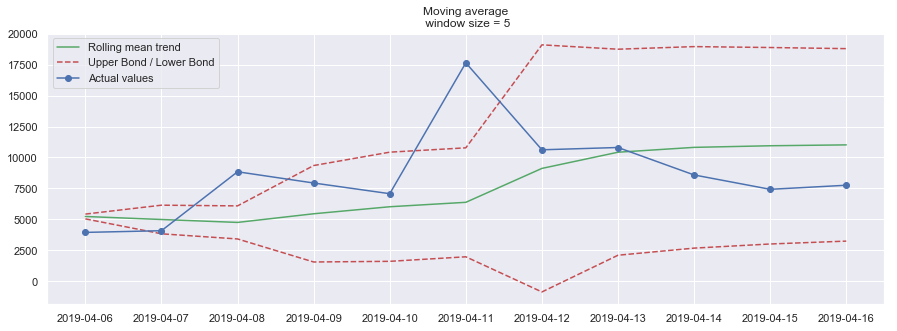

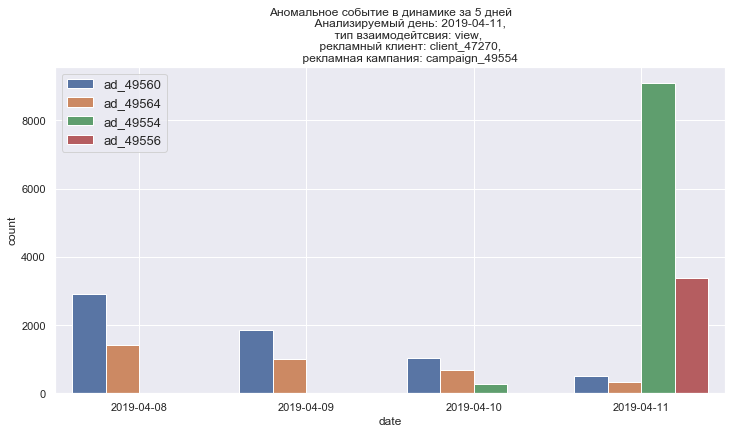

In [42]:
anomalyAnalysis(data="test_data.csv", check_day='2019-04-11', n_days=5, freq='60min', max_cnt=10)

__*Вывод:*__

11 апреля прозошло резкое увеличение просмотра рекламного объявления 'ad_49554' и 'ad_49556'. При этом первое рекламное объявление появилось накануне вечером - 10 апреля, а второе - является скорее всего новым.
Данные рекламные объявления относятся к рекламной кампании 'campaign_49554', рекламному клиенту 'client_47270', рекламному агентству 'agency_2'.